In [112]:
# setup: imports

import scanpy as sc
import anndata as ad

from scripts.utils import setup_validate_paths, harmony_integrate
from scripts.paths import DATA, FIGURES, OUTPUT

# setup: path constants

POSCABLO_PATH = DATA / "rna_annotation_normalized.h5ad"
PNE_PATH = DATA / "pne-bonemarrow.h5ad"
FIGURES_NB = FIGURES / "cluster-age-integrated"
OUTDIR_NB = OUTPUT / "cluster-age-integrated"

# setup: verify paths

setup_validate_paths(
    required_paths=[POSCABLO_PATH, PNE_PATH], output_dirs=[FIGURES_NB, OUTDIR_NB]
)

# can break rendering saved objects in anndata < 0.11
ad.settings.allow_write_nullable_strings = True

In [ ]:
# set up objects
poscablo = sc.read_h5ad(POSCABLO_PATH)
pne = sc.read_h5ad(PNE_PATH)

# filter for control HSCs
pne_ctrl = pne[pne.obs["Treatment"] == "CONTROL"]
common_genes = poscablo.var_names.intersection(pne_ctrl.var_names)
# pne_ctrl_hsc = pne_ctrl[pne_ctrl.obs["predicted_cell_type"].isin({"HSC"})].copy()
pne_ctrl_hsc = pne_ctrl   # try whole dataset
del pne

"""
Note on solely spiking in PNE Ctrl HSCs:

PC1 / PC2 seem to capture variation within each cell type as opposed to differences between cell types (HSC vs MKP)
PC1 (no harmony) captured a little difference between HSCs & MKPs, however same variation was a batch effect

H: diff between yHSCs (PNE) and MKPs (Posc) are covariate with batch effect
-> PCs cannot tell differences between HSC/MKP AT ALL
-> Harmony (which builds on PCs) sort of sees them all as the same 'group'

Note that whole dataset integration does allow for integration w/o batch effects,
we believe this is due to batch effects being drawn away from HSC/MKP differences
when more cell types are added
"""

# standardize poscablo metadata to pne conventions
poscablo.obs.drop(
    columns=[
        "nCount_RNA",  # dupe of n_counts
        "nFeature_RNA",  # dupe of n_genes_by_counts
        "pct_counts_mt",  # empty, seurat ver has actual data
    ],
    inplace=True
)
poscablo.obs.rename(
    columns={
        "rna_annotation": "predicted_cell_type",
        "orig.ident": "Sample",
        "percent.mt": "pct_counts_mt",
        "Age": "age_group",
    },
    inplace=True,
)

# set up age columns
pne_ctrl_hsc.obs["age_group"] = "Young"

# add dataset
poscablo.obs["dataset"] = "poscablo"
pne_ctrl_hsc.obs["dataset"] = "pne"

# keep common genes among datasets

poscablo = poscablo[:, common_genes].copy()
pne_ctrl_hsc = pne_ctrl_hsc[:, common_genes].copy()

# split by ages
joint = sc.concat(adatas=[poscablo, pne_ctrl_hsc])

joint = joint[joint.obs['predicted']]

young = joint[joint.obs["age_group"] == "Young"].copy()
old = joint[joint.obs["age_group"] == "Old"].copy()
# del poscablo, pne_ctrl

/tmp/ipykernel_2667244/3619033756.py:32: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pne_ctrl_hsc.obs["age_group"] = "Young"


In [114]:
# compute umap coordinates

# total (poscablo + pne HSCs)
sc.pp.pca(joint)
harmony_integrate(joint, key="dataset")
sc.pp.neighbors(joint, use_rep="X_pca_harmony")
sc.tl.umap(joint)

# old (only poscablo cells)
sc.pp.pca(old)
sc.pp.neighbors(old)
sc.tl.umap(old)

# young (poscablo + pne HSCs)
sc.pp.pca(young)
harmony_integrate(young, key="dataset")
sc.pp.neighbors(young, use_rep="X_pca_harmony")
sc.tl.umap(young)

2026-02-20 16:00:28,446 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-20 16:00:28,458 - harmonypy - INFO -   Parameters:
2026-02-20 16:00:28,459 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-20 16:00:28,460 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-20 16:00:28,460 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-20 16:00:28,461 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-20 16:00:28,461 - harmonypy - INFO -     nclust: 100
2026-02-20 16:00:28,462 - harmonypy - INFO -     block_size: 0.05
2026-02-20 16:00:28,463 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-20 16:00:28,464 - harmonypy - INFO -     theta: [2. 2.]
2026-02-20 16:00:28,465 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-20 16:00:28,465 - harmonypy - INFO -     verbose: True
2026-02-20 16:00:28,466 - harmonypy - INFO -     random_state: 0
2026-02-20 16:00:28,466 - harmonypy - INFO -   Data: 50 PCs × 30404 cells
2026-02-20 16:00:28,466 - harmonypy - INFO

In [115]:
# save objects for reference

joint.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented.h5ad")
old.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented_old.h5ad")
young.write_h5ad(filename=OUTDIR_NB/"poscablo_augmented_young.h5ad")

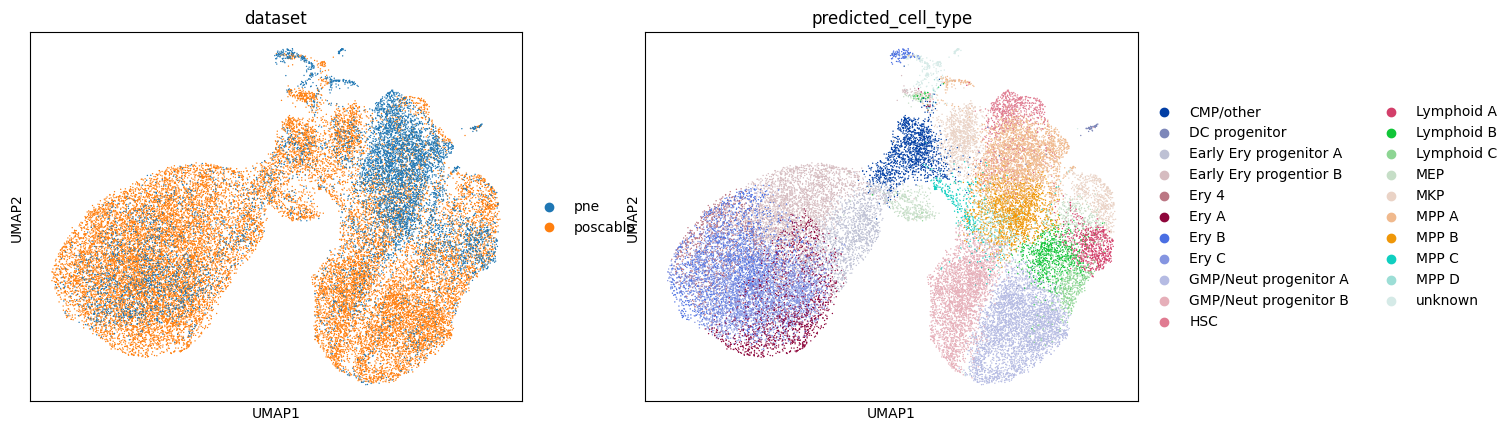

In [116]:
# all poscablo + pne ctrl hscs (young)... fishy...
sc.pl.umap(joint, color=['dataset', 'predicted_cell_type'])

/home/aspandit/lab/age-analysis/.venv/lib/python3.14/site-packages/scanpy/plotting/_utils.py:507: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{value_to_plot}_colors"] = colors_list


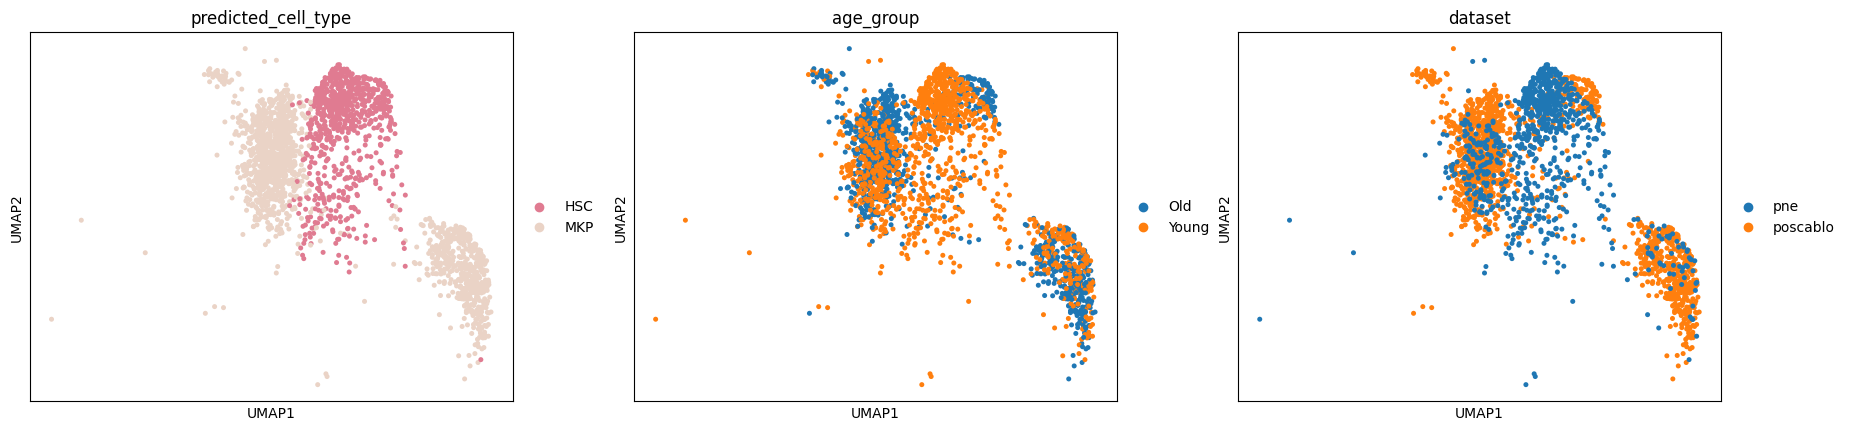

In [117]:
# subsetting hscs/mkps from joint... still weird...
sc.pl.umap(
    adata=joint[joint.obs['predicted_cell_type'].isin({'HSC', 'MKP'})],
    # adata=joint,
    color=['predicted_cell_type', 'age_group', 'dataset']
)

2026-02-20 16:02:59,017 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-20 16:02:59,042 - harmonypy - INFO -   Parameters:
2026-02-20 16:02:59,042 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-20 16:02:59,043 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-20 16:02:59,043 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-20 16:02:59,043 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-20 16:02:59,044 - harmonypy - INFO -     nclust: 77
2026-02-20 16:02:59,044 - harmonypy - INFO -     block_size: 0.05
2026-02-20 16:02:59,045 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-20 16:02:59,045 - harmonypy - INFO -     theta: [2. 2.]
2026-02-20 16:02:59,046 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-20 16:02:59,046 - harmonypy - INFO -     verbose: True
2026-02-20 16:02:59,047 - harmonypy - INFO -     random_state: 0
2026-02-20 16:02:59,047 - harmonypy - INFO -   Data: 50 PCs × 2307 cells
2026-02-20 16:02:59,047 - harmonypy - INFO -

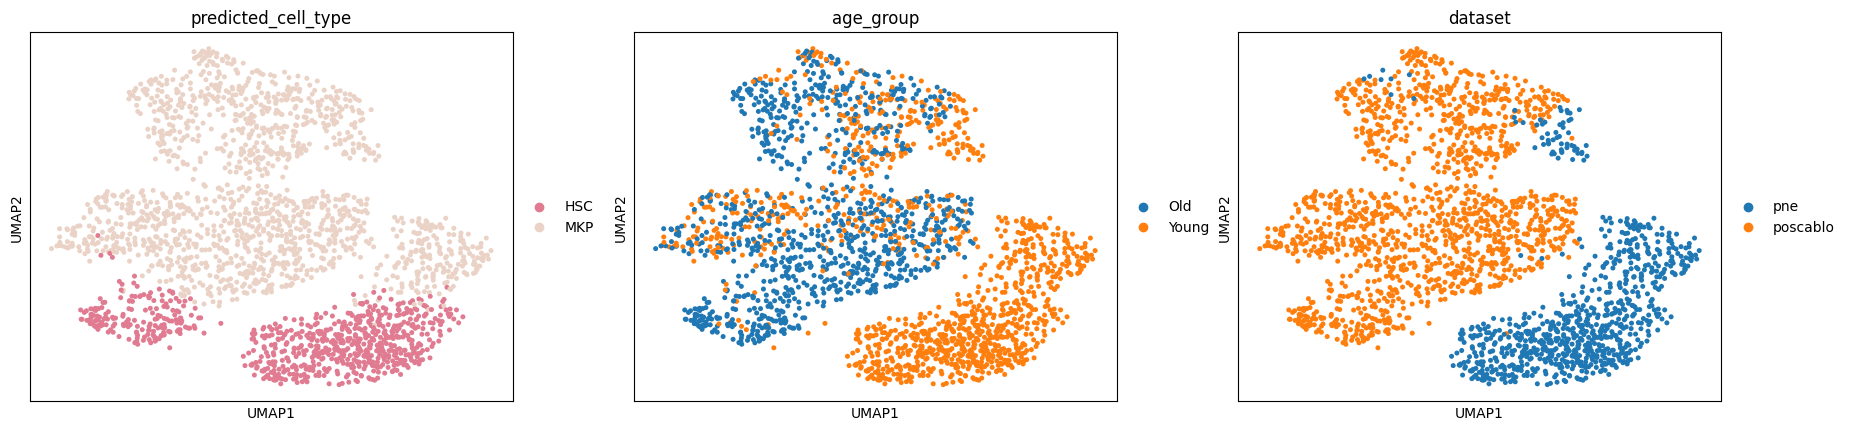

In [118]:
# whole notebook cell: subset HSC/MKP populations, then recompute all steps (pca, harmony, neighbors, umap)
# VERY WEIRD... maybe a data thing?

hsc_mkp = joint[joint.obs['predicted_cell_type'].isin({'HSC', 'MKP'})].copy()

sc.pp.highly_variable_genes(hsc_mkp, n_top_genes=4000)  # removing makes negligible difference

sc.pp.pca(hsc_mkp)
harmony_integrate(hsc_mkp, key="dataset")  # tried tweaking theta param 2, 4, 10, no diff
sc.pp.neighbors(hsc_mkp)
sc.tl.umap(hsc_mkp)

sc.pl.umap(hsc_mkp, color=['predicted_cell_type', 'age_group', 'dataset'])

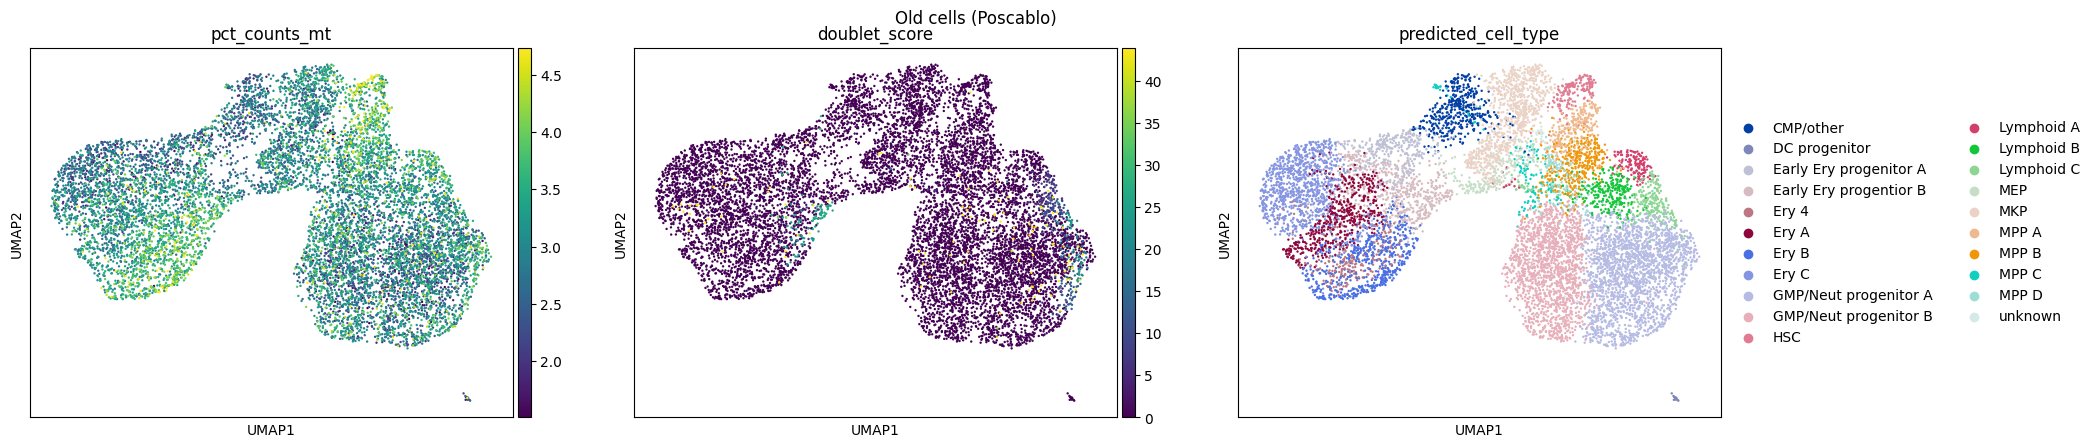

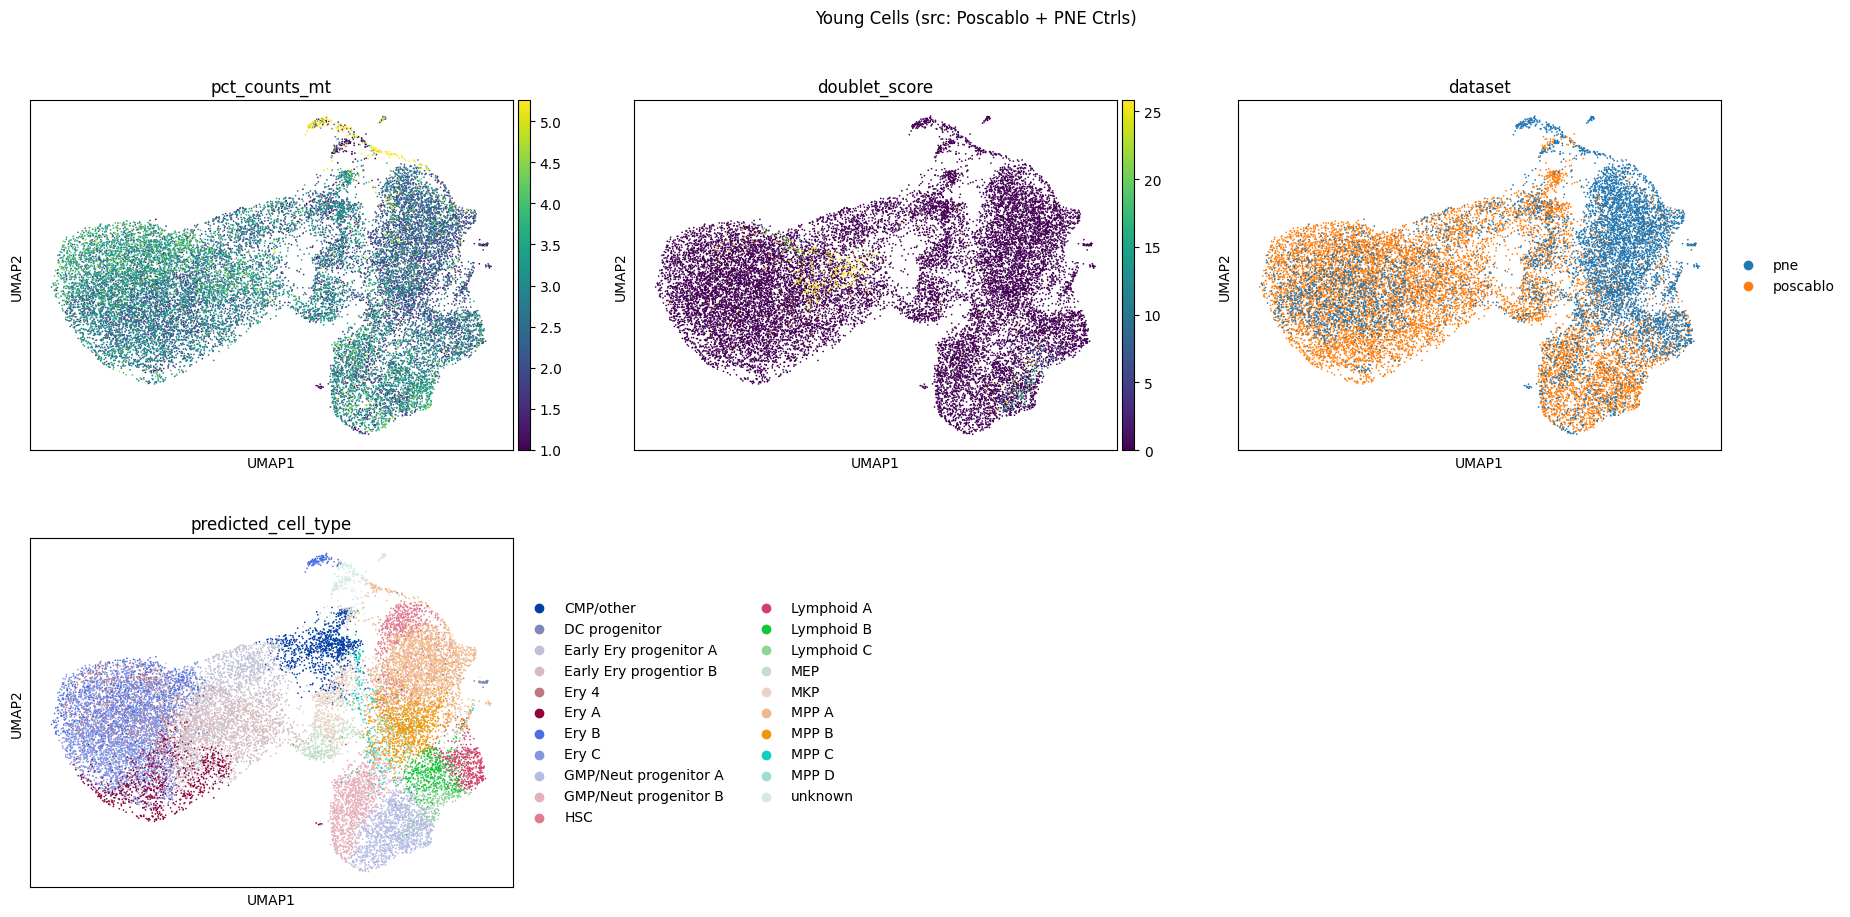

In [119]:
# plot age-specific umaps
oldfig = sc.pl.umap(
    adata=old,
    color=["pct_counts_mt", "doublet_score", "predicted_cell_type"],
    vmax="p99",
    vmin="p1",
    return_fig=True,
    show=False
)

youngfig = sc.pl.umap(
    adata=young,
    color=["pct_counts_mt", "doublet_score", "dataset", "predicted_cell_type"],
    vmin='p1',
    vmax='p99',
    ncols=3,
    return_fig=True,
    show=False
)

oldfig.suptitle("Old cells (Poscablo)")
youngfig.suptitle("Young Cells (src: Poscablo + PNE Ctrls)")
oldfig.show()
youngfig.show()

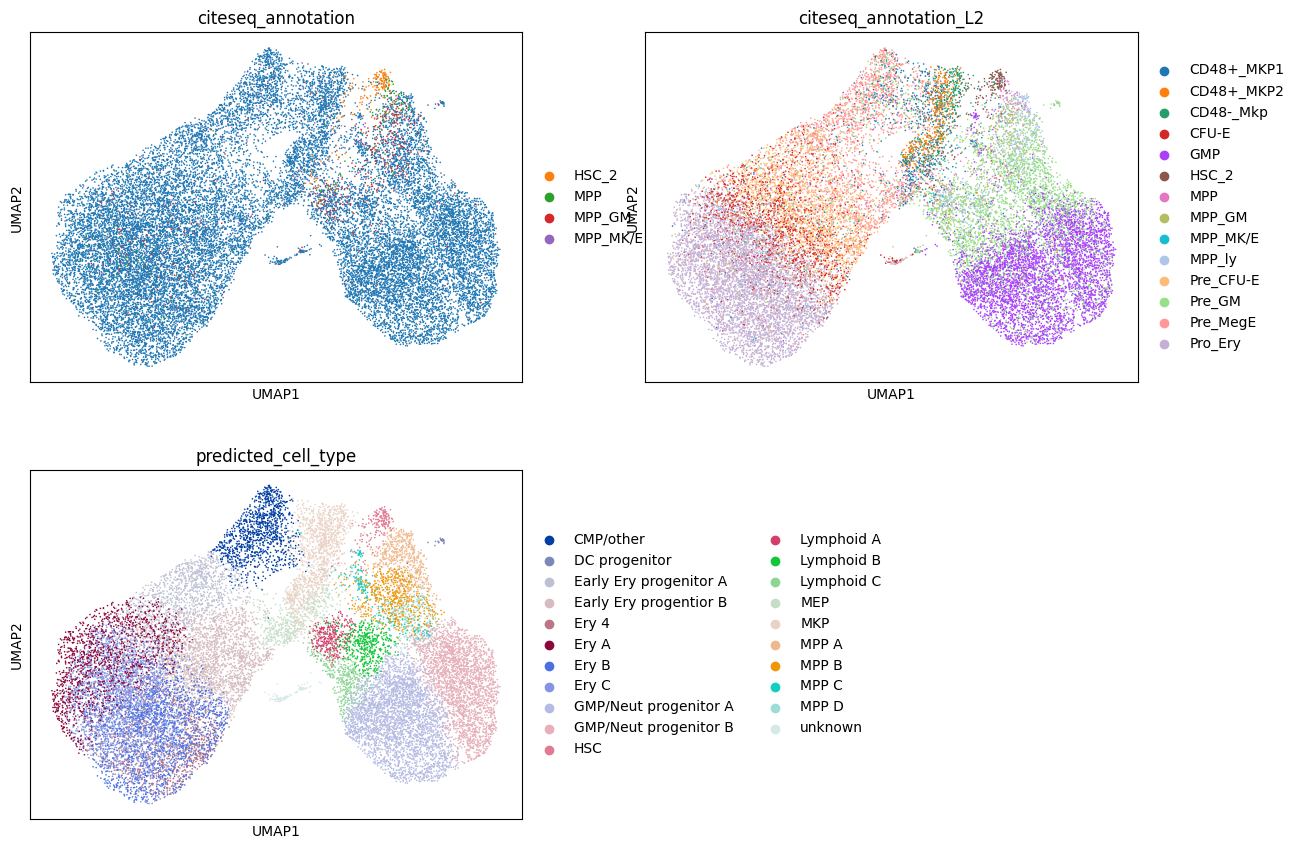

In [120]:
# just curious
sc.pl.umap(poscablo, color=['citeseq_annotation', 'citeseq_annotation_L2', 'predicted_cell_type'], ncols=2)

In [121]:
poscablo = sc.read_h5ad(POSCABLO_PATH)

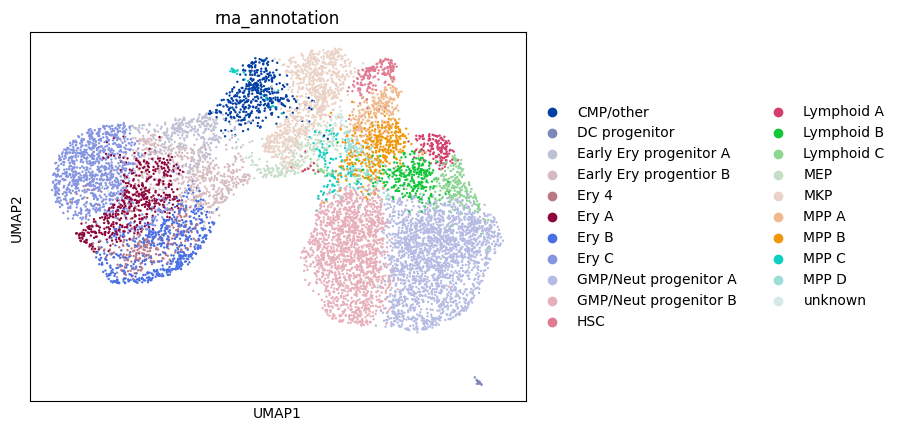

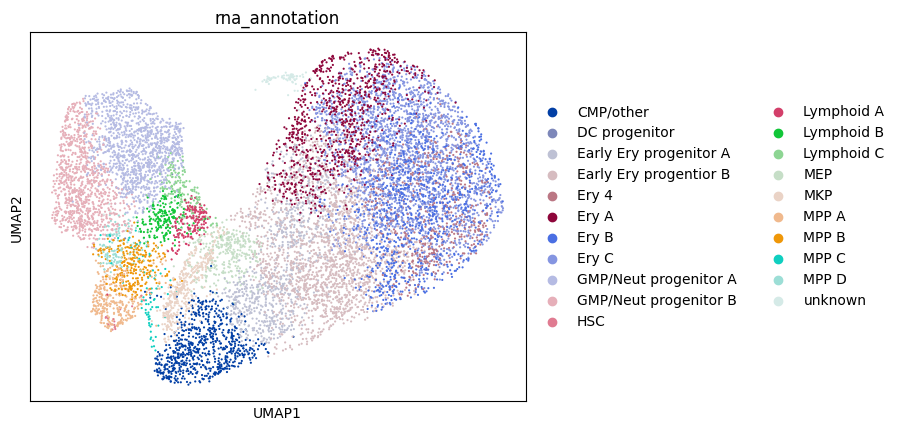

In [122]:
common_genes = poscablo.var_names.intersection(pne_ctrl_hsc.var_names)
old_posc = poscablo[poscablo.obs['Age'] == 'Old'][:, common_genes].copy()
young_posc = poscablo[poscablo.obs['Age'] == 'Young'][:, common_genes].copy()

for adata in old_posc, young_posc:
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='rna_annotation')

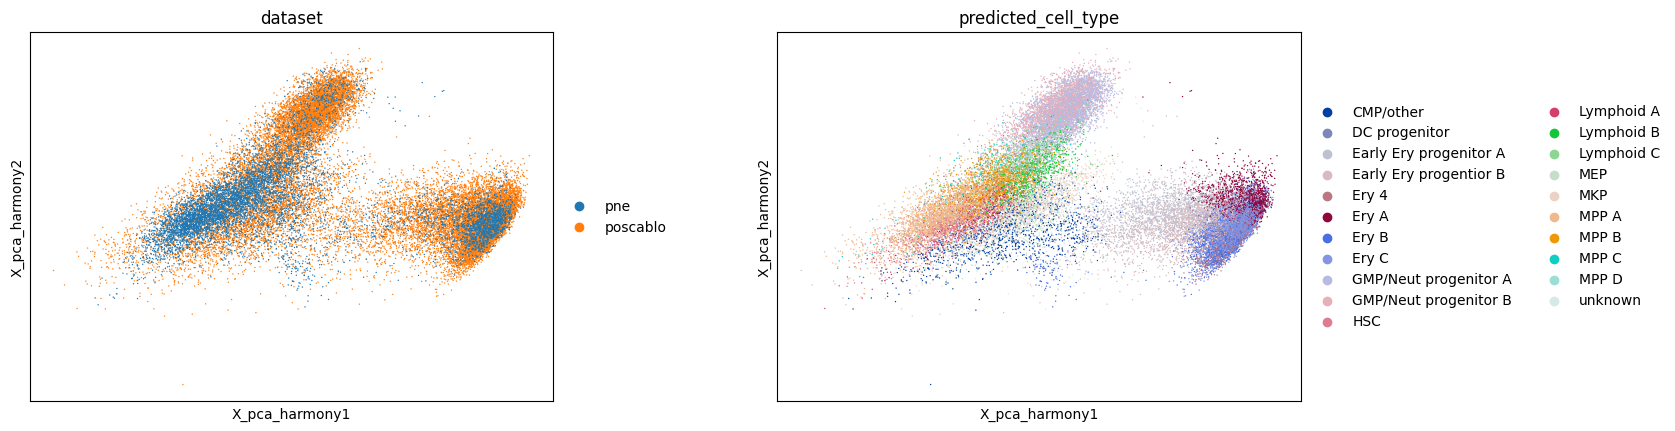

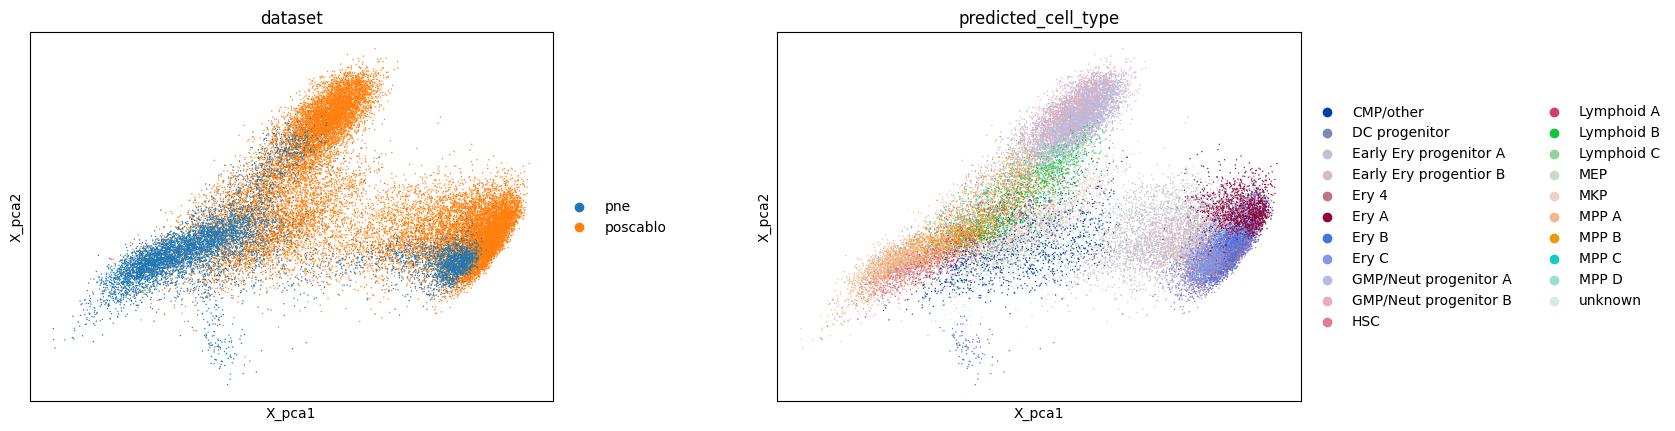

In [139]:
cells = {"HSC", "MKP", "Ery A", "GMP/Neut progenitor A"}
colors = [ 'dataset',"predicted_cell_type"]

sc.pl.embedding(
    basis="X_pca_harmony",
    adata=joint,
    color=colors, wspace=0.3
)

sc.pl.embedding(
    basis="X_pca",
    adata=joint,
    color=colors, wspace=0.3
)

In [ ]:
pc1, pc2 = joint.obsm['X_pca_harmony'].T[:2]



array([[18.079634 , 15.595423 , 14.878791 , ..., 12.7504015, -6.889858 ,
        -6.928597 ],
       [-3.431507 , -8.120808 , -8.322022 , ..., -4.430332 , 16.708614 ,
        12.340274 ]], shape=(2, 30404), dtype=float32)

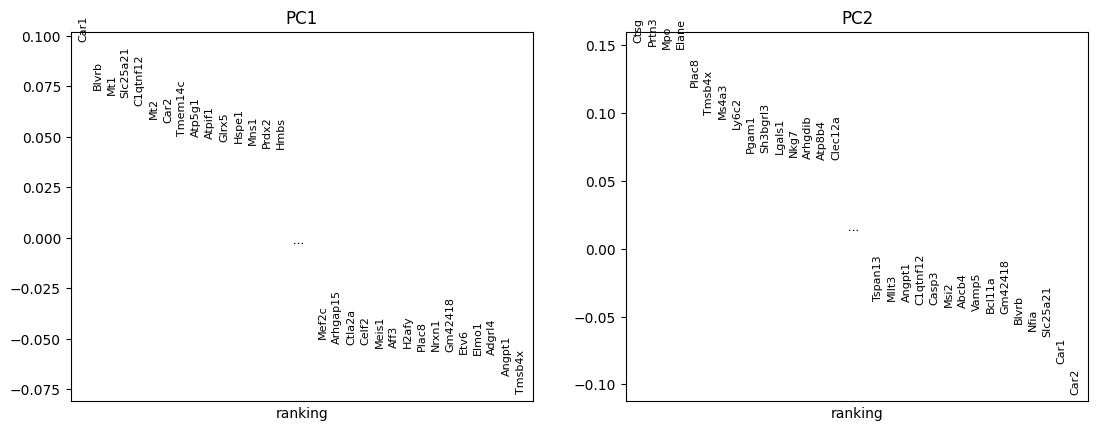

In [133]:
sc.pl.pca_loadings(joint, [1,2])

array([[ 8.94840749e-04,  2.25004871e-04,  2.86529772e-04, ...,
         1.85871366e-04, -1.39724487e-03, -1.92736887e-04],
       [-6.31750163e-06,  2.76916599e-05,  5.88736293e-06, ...,
        -1.68994025e-04, -1.99989863e-05,  4.49031577e-05],
       [ 2.18297094e-02,  6.76354021e-03,  6.08045049e-03, ...,
         6.56038336e-03,  2.57871323e-03,  1.34593835e-02],
       ...,
       [-2.24833637e-02,  5.25530614e-03,  1.34033104e-02, ...,
        -5.71067538e-03, -2.12522428e-02,  1.30684236e-02],
       [-7.32655358e-03,  1.70012284e-02,  2.19180528e-03, ...,
        -2.09855307e-02,  1.37630224e-01, -1.18151186e-02],
       [-1.27604790e-03, -1.07180420e-03, -6.16023666e-04, ...,
        -3.52556724e-03, -8.14363174e-03, -2.53542862e-03]],
      shape=(20383, 50), dtype=float32)